In [1]:
import os
import pickle
from tqdm.notebook import tqdm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import norm

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# afinn
from afinn import Afinn 

# transformer
from transformers import pipeline

In [2]:
pd.__version__

'1.3.3'

# Sentiment score investigations
This notebook investigates the properties of two different sentiment score approaches; 1) the lexicon- and rule-based VADER approach and 2) a tranformer based approach using a pretrained BERT to model sentiment of quotes. A third score - the naïve AFINN lexicon-based approach - is also provided but is deemed to simple from the beginning and serve as a possible comparison (if wanted). 

### Initial analyses
We will start by investigating three different approaches for adding sentiment scores
to quotes. One uses the simpler dictionary-based sentiment ranking system of
the [AFINN lexicon](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf). Another is the [VADER sentiment module](https://github.com/cjhutto/vaderSentiment) that was used in the tutorial on text handling. This is lexicon- and rule-based and tuned to sentiments occuring in textual data from socia media and has the advantage to AFINN that it includes the negative, neutral, positive as well as the compound (combined and scaled between -1 and 1) sentiment scores of a string whereas this should be manually handled with AFINN. The last approach uses
the nowadays hyped transformers, where a pretrained transformer
from [HuggingFace](https://github.com/huggingface/transformers) determined to use the distilled BERT model that is unsenstive to the case of words (the default model). We choose to stay with the default pretrained model as the distillation makes it faster and the unsensitiveness to casing as we want to examine quotes and not online textual expressions as tweets. With the latter we mean that the casing is redundant to incorporate when dealing with spoken text compared to written text expressions - as an example the case sensitive model would be of interest to use for tweets where "FUCK" and "fuck" should definitely be related to different scores. The default model the model `distilbert-base-uncased` and we would like to refer to the [paper accompanying the model](https://arxiv.org/abs/1910.01108) for more technical details.

In general we put more weight on the VADER and Transformer approaches as they are less naïve but we keep the AFINN as an option that might be a "funny" feature for interactive plots.

In [3]:
#!pip install Afinn
#!pip install transformers[sentencepiece]

In [4]:
afn = Afinn()

In [5]:
vaderAnalyzer = SentimentIntensityAnalyzer()

In [6]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


We initially test the approaches on a couple of examples to get an idea of how and whether they work or not. A helper function for the AFINN and VADER objects is used for similar output as the transformer.

In [7]:
def output_aux(score, threshold=0):
    """Helper function for outputting similar output as the transformer."""
    
    if score < threshold:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [8]:
negative_sentence = "Fuck you fucking dumb BERT model, you dumbass"
print(f'"{negative_sentence}":\n Transformer: \t {classifier(negative_sentence)}\n AFINN:\t\t {output_aux(afn.score(negative_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(negative_sentence)["compound"])}\n')

positive_sentence = "I love my ADA group - they're the best! <3"
print(f'"{positive_sentence}":\n Transformer: \t {classifier(positive_sentence)}\n AFINN:\t\t {output_aux(afn.score(positive_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(positive_sentence)["compound"])}\n')

"Fuck you fucking dumb BERT model, you dumbass":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.9992602467536926}]
 AFINN:		 [{'label': 'NEGATIVE', 'score': -14.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.8932}]

"I love my ADA group - they're the best! <3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.9998805522918701}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 6.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.9117}]



Based on this single (however super representative!!!) example we see that all three approaches work but that the output scores are quite differently scaled. This is due to the fact that the transformer has a softmax layer in the end and therefore outputs the probability of the most probable label - which is either "POSITIVE" or "NEGATIVE". On the other hand AFINN accumulates a the score of both positive and negative words to get a single score. The AFINN score can thus strongly depend on the length of a sentence and we would need to introduce a normalization term. The VADER scores are as mentioned pre-scaled and normalized in the range between -1 and 1 in the module implementation.

In [9]:
symbols = ['<3', ':-)', ':-(']

for sym in symbols:
    print(f'"{sym}":\n Transformer: \t {classifier(sym)}\n AFINN:\t\t {output_aux(afn.score(sym))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(sym)["compound"])}\n')

"<3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.979346513748169}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.4404}]

":-)":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.5607805848121643}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.3182}]

":-(":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.87599778175354}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.3612}]



As seen above some of the approaches differ when examining symbols like smileys and hearts. Here, the manually defined AFINN lexicon can not encounter such tokens, where the transformer on the contrary has learned to encounter these and in fact do quite a good job (except for the 'positive' smiley). The rule-based lexicon of VADER has indeed also learned the mapping of such smileys and symbols. Even though symbols like these are not immediately associated with quotes - as quotes are text capturing spoken language - it might come in as a good feature that the transformer and the VADER approaches are more complex and understand the local sentiment of subtokens better than AFINN. We therefore already disregard AFINN as the better approach but keep it as a possible feature for interactive plots as previously mentioned. We will investigate the other two a bit more and apply all three scores to a new dataframe.

### Applying sentiment scores to the data (skipable)
This section can be skipped if it has previously been executed!

First, we load the data that was previously processed. The pickled file was created with pandas 1.3.3. and has to be loaded with the same pandas version.

In [46]:
# Specifying filename and directory
data_dir = os.getcwd() + os.sep + 'data'
filepath = rf"{data_dir}{os.sep}Quotebank_processed.pkl"

df = pd.read_pickle(filepath)
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1412
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,700
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q16195496, Q18202175, Q7436225, Q7436228, Q12...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,999
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,1926
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,7091


Now we compute the sentiment scores with AFINN score, VADER score and the BERT transformer based score. We do two things here; first we redefine the auxiliary function used to change the output format such that it normalizes the sentiment by the length of a quote (defined by number of words splitted at whitespaces) when using AFINN and second we are aware that the transformer is limited to a certain input sequence length and add a NaN-value for a quote if it is longer than this maximum sequence length. Later we will try to scale the different scores such that they are comparable.

In [11]:
def afn_aux(quote):
    """Helper function for outputting similar output as the transformer."""
    
    score = afn.score(quote) / len(quote.split(" "))

    if score < 0:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [12]:
sentiments_AFINN = [afn_aux(quote) for quote in tqdm(df.quotation)]

  0%|          | 0/53503 [00:00<?, ?it/s]

In [13]:
sentiments_VADER = [output_aux(vaderAnalyzer.polarity_scores(quote)['compound']) for quote in tqdm(df.quotation)]

  0%|          | 0/53503 [00:00<?, ?it/s]

In [14]:
# the model is limited to handling sequences of a prespecified length.
# We handle this by using the try-except statement and add a nan-value where the 
# BERT can't handle the input quote.
sentiments_BERT = []
for quote in tqdm(df.quotation):
    try:
        BERT_score = classifier(quote)
        sentiments_BERT.append(BERT_score)
    except RuntimeError:
        sentiments_BERT.append(np.nan)

  0%|          | 0/53503 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


We temporarily add the sentiment scores to the dataframe for easier removing the NaN values that might occur in the BERT sentiment scores.

In [47]:
df['sentiments_AFINN'] = sentiments_AFINN
df['sentiments_VADER'] = sentiments_VADER
df['sentiments_BERT'] = sentiments_BERT

We check how many NaN values we created by use of the transformer and remove them. The justification for this is mainly that we do not have time for training a new model and prefer using a pretrained one that has already shown a prominent performance and that it seems plausible that (super) long quotes are erroneous data that has not been removed in the Quotebank approach of scraping the quotes from newspaper articles. Below we print out 3 random of the 88 quotes that were too long for the transformer to handle.

In [48]:
print(f"Number of NaN-values in BERT sentiment score: {df.isnull().any(axis=1).sum()}")

Number of NaN-values in BERT sentiment score: 95


In [50]:
NaN_quotes = df[df.isnull().any(axis=1)]

random_ids = np.random.randint(0, len(NaN_quotes), size=3)
for random_id in random_ids:
    print(f"{NaN_quotes.quotation.iloc[random_id]}\n")

You really think you can stop me, Gunslinger? „ ~ The Man in Black to Gunslinger. Gallery Edit Images Edit Randall Flagg as the Man in Black in The Dark Tower series. Flagg Flagg's monstrous form. The death of the Man in Black. Add a photo to this gallery Trivia Edit Randall Flagg is regarded as Stephen King's most popular villain. As such, King himself regards him as the greatest villain he ever wrote. Many fans suspect that the dark form at the end of The Long Walk to be an incarnation of Randall Flagg somehow. Navigation Edit The Headlined Villains 2009 January Shadow Queen February None March Lord Voldemort April Darth Vader May Dahlia Gillespie June Smithy July Manfred Von Karma August Light Yagami September Lee Woo-jin October Imhullu November Gaston LeGume December None 2010 January Leatherface (original) February GLaDOS March Edward Hyde April Dimentio May The Chairstealer June Walter Sullivan July Vlad the Impaler August None September Audrey II October Albert Wesker November 

In [51]:
df = df.loc[-df.isnull().any(axis=1)]
df.index = np.arange(len(df))

df.isnull().any()

quotation           False
speaker             False
qids                False
date                False
numOccurrences      False
probas              False
urls                False
movie               False
shared_ID           False
sentiments_AFINN    False
sentiments_VADER    False
sentiments_BERT     False
dtype: bool

After having removed the NaNs, we now extract the label and score from the sentiment scores dictionaries and create individual attributes for these for each sentiment approach. This is done for easier access in future tasks.

In [54]:
AFINN_label, AFINN_score = [], []
VADER_label, VADER_score = [], []
BERT_label, BERT_score = [], []

for i in tqdm(range(len(df))):
    label, score = df.sentiments_AFINN[i][0].values()
    AFINN_label.append(label), AFINN_score.append(score)
    
    label, score = df.sentiments_VADER[i][0].values()
    VADER_label.append(label), VADER_score.append(score)
    
    label, score = df.sentiments_BERT[i][0].values()
    BERT_label.append(label), BERT_score.append(score)
    

# update sentiment attributes
df['AFINN_label'] = AFINN_label
df['AFINN_score'] = AFINN_score
df['VADER_label'] = VADER_label
df['VADER_score'] = VADER_score
df['BERT_label'] = BERT_label
df['BERT_score'] = BERT_score

# remove attributes with dictionary structure
df = df.drop(['sentiments_AFINN', 'sentiments_VADER', 'sentiments_BERT'], axis=1)
df.head()

  0%|          | 0/53408 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1412,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,700,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q16195496, Q18202175, Q7436225, Q7436228, Q12...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,999,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,1926,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,7091,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218


### Investigating the sentiment attributes (specific)

We now want to investigate the distribution of the sentiment scores for each of the approaches. We will invest all of the three but with an emphasis on VADER and the Transformer-based approach. We start by extracting the scores and label from the dictionary structure that the scores are stored and vizualising the distribution of the BERT and VADER sentiments before re-scaling them.

In [55]:
# Extracting sentiment scores and labels from the 
VADER_scores = df.VADER_score
VADER_labels = df.VADER_label

BERT_scores = df.BERT_score 
BERT_labels = df.BERT_label 

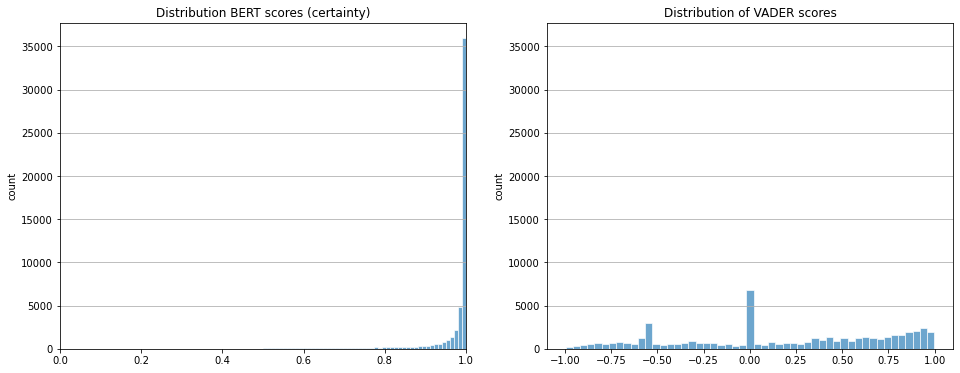

In [56]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
BERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution BERT scores (certainty)")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

From these plots we make some interesting explorations: as the BERT scores are softmax outputs we see that the BERT is extremely certain in it's predictions, meaning that the model tends to be more than 90-95% percent certain that the label it is predicting is correct. Furthermore, we are confirmed that we need to change the score for the BERT predictions such that it distinguishes negative from positive scores if it is to be compared with the VADER scores. On the other hand when we look at the VADER scores, it is clearly seen that the sentiment is pretty evenly distributed with exceptions around -0.5 and 0. The spike at 0 reveals that the VADER scores contain additional properties than the BERT, as it can be used to label a sentence neutral.

To deal with the issues of the BERT scores we start by expressing all the scores as the models probability of labelling the given score as "POSITIVE". In this way the scores are probabilities of the POSITIVE class that can take values from 0 to 1.

In [57]:
# change the negative labels as probability of being positive
df['positive_BERT_score'] = df.BERT_score
df.loc[df.BERT_label == 'NEGATIVE', 'positive_BERT_score'] = 1 - BERT_scores[BERT_labels == 'NEGATIVE'] #[output_aux(score, threshold=0.5) for score in BERT_scores]

posBERT_scores = df['positive_BERT_score']

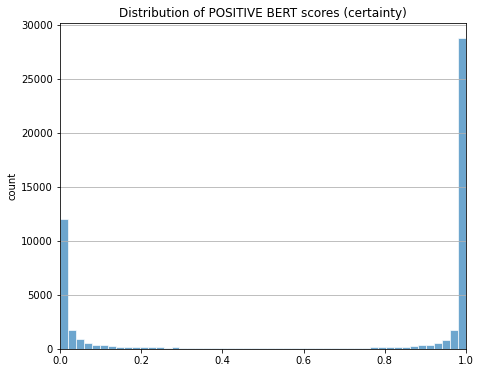

In [58]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
posBERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.set_title("Distribution of POSITIVE BERT scores (certainty)")
ax1.xaxis.grid(False)
plt.show()

What seems to be the situation for the BERT scores is that there are more POSITIVE labels that the BERT is super certain about. Before investigating the relation between positive and negative labelled classes we want to rescale the BERT scores to the same scale as the VADER scores, such that they are comparable. Since the BERT scores are outputs of a softmax which generalizes to the sigmoid in the binary case (which we have here) we revert the BERT scores (reverted sigmoid) and scale them to the range -1 to 1.

In [59]:
revertedBERT = np.log(posBERT_scores / (1-posBERT_scores))

In [60]:
df['scaledReverted_BERT_score'] = 2*(revertedBERT-np.min(revertedBERT)) / (np.max(revertedBERT) - np.min(revertedBERT)) - 1
scaledRevertedBERT = df['scaledReverted_BERT_score']

We now have all sentiment scores we are interested in and save them in a pickle.

In [61]:
# Save loaded DataFrame as pickle for faster loading time in the future
filename = f"Quotebank_sentiment"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\Documents\EPFL\Courses\CS-401_ADA\ada-2021-project-f-jab\exploratory\data 

Shape of dataframe: (53408, 17)


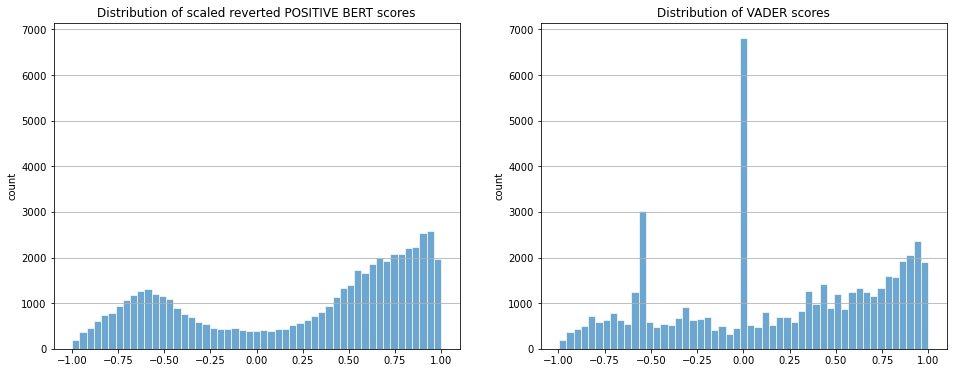

In [62]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
scaledRevertedBERT.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution of scaled reverted POSITIVE BERT scores")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

So we see that the scores are now comparable and actually look somewhat similar. We still see that very few of the BERT scores are classified as neutral and tend to have the density in a negative and a positive cluster. The two approaches sentiment prediction especially resemble eachother when comparing with the normalized AFINN score in the plot below. We do not scale this to a range of -1 to 1 as it seems to be normally distributed and would therefore be heavily influenced by outliers.

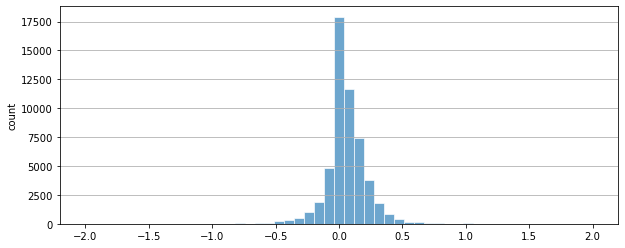

In [63]:
AFINN_scores = df.AFINN_score 
AFINN_labels = df.AFINN_label

plt.figure(figsize=(10,4))

ax = plt.subplot(111)
AFINN_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax.xaxis.grid(False)
ax.set_ylabel('count')

plt.show()

We now want to examining the mean scores and distribution of labels across the classes "POSITIVE" and "NEGATIVE" to get a sense of how each approach characterizes the quotes. In the below plot we visualize the mean sentiment scores for each approach with a 95% confidence interval as well as the distribution of POSITIVE vs. NEGATIVE labels categorized by each approach. Be aware that the AFINN scores do not make sense to directly compare to the other ones in regards to the continuous score as it is on a different scale, for which reason it is left out.

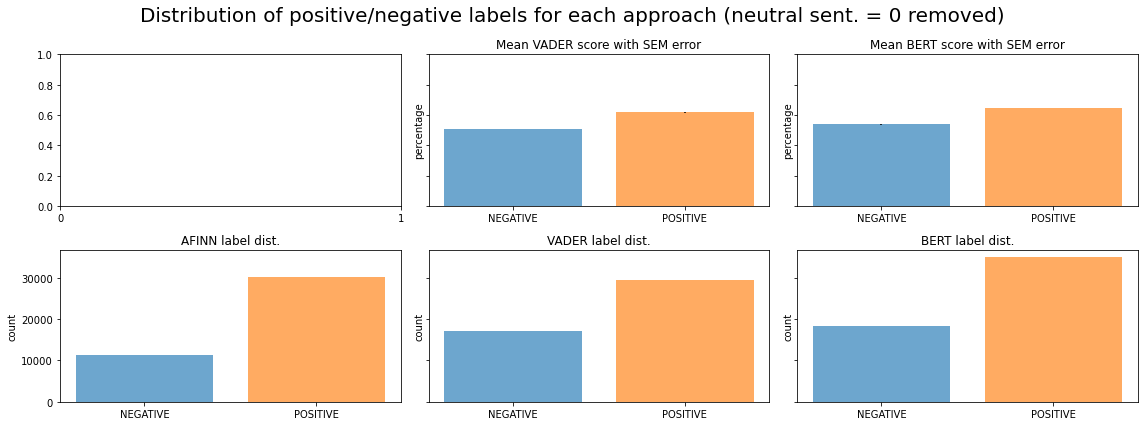

In [64]:
fig, ax = plt.subplots(2,3, figsize=(16,6),sharey='row')

attributes = ["AFINN", "VADER", "BERT"]
x = [0,1]    

for i, att in enumerate(attributes):
    if att == 'BERT':
        sent_scores = df[f'scaledReverted_BERT_score']
    else:
        sent_scores = df[f'{att}_score']

    sent_labels = df[f'{att}_label'] 
    ids_without_neutral = -np.logical_and(sent_labels=="POSITIVE", sent_scores==0)
    
    labels, counts = np.unique(sent_labels[ids_without_neutral], return_counts=True)
    temp = pd.DataFrame({'score': sent_scores[ids_without_neutral], 'labels': sent_labels[ids_without_neutral]})
    classes = temp.groupby(by='labels')
    
    err = (1.96*classes.std()/np.sqrt(sum(counts))).T.to_numpy()[0]
    
    ax[0, i].set_xticks(x)       
    if i != 0:
        ax[0, i].bar(x, abs(classes.mean().T.to_numpy()[0]), yerr=abs(err), color=['C0', 'C1'], alpha=0.65)
        ax[0, i].set_xticklabels(labels)
        ax[0, i].set_title(f"Mean {att} score with SEM error")
        ax[0, i].set_ylim(0,1)
        ax[0, i].xaxis.grid(False)     
        ax[0, i].set_ylabel("percentage")
        
    ax[1, i].bar(x, counts, color=['C0', 'C1'], alpha=0.65)
    ax[1, i].set_xticks(x)
    ax[1, i].set_xticklabels(labels)
    ax[1, i].set_title(f"{att} label dist.")
    ax[1, i].xaxis.grid(False)
    ax[1, i].set_ylabel("count")


plt.suptitle("Distribution of positive/negative labels for each approach (neutral sent. = 0 removed)", fontsize=20)
plt.tight_layout()
plt.show()

The first row of the above subplot reveals that the scores obtained with VADER and BERT are similar. The second row reveals that there is an overweight of the POSITIVE label no matter which approach is used - also when the sentiment scores equal to 0 are removed. Furthermore, this reveals the first thing about the sentiment of quotes about movies - namely that there is a slight overweigth of positively associated quotes. Lets investigate the labels of one approach when conditioning on the other (between VADER and BERT).

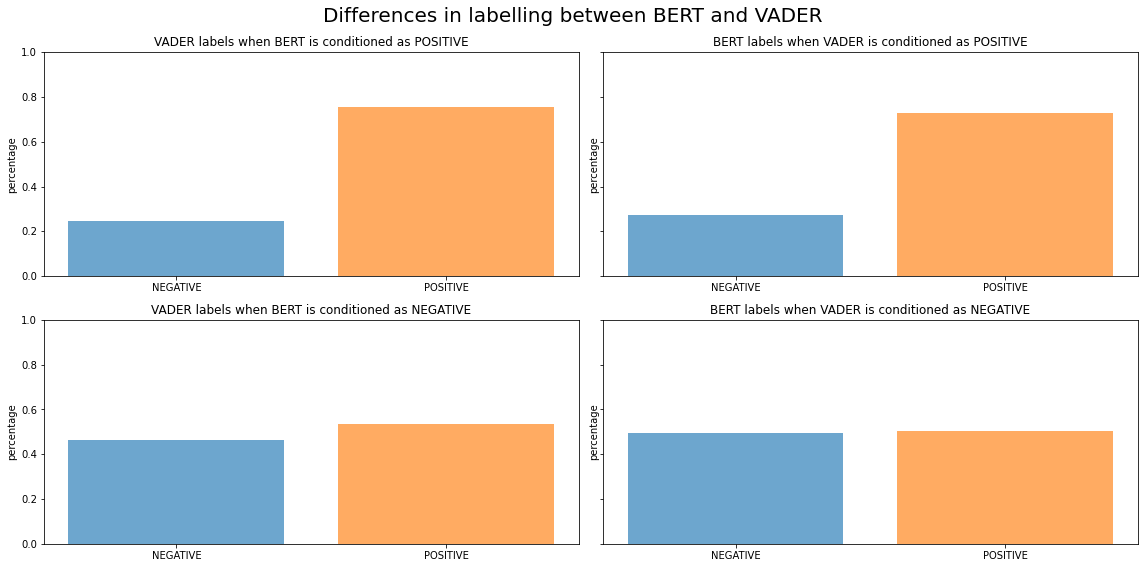

In [65]:
fig, ax = plt.subplots(2, 2, figsize=((16,8)), sharey=True)
x = [0, 1]

helper_dict = {"sent1": [(VADER_labels, "VADER"), (VADER_labels, "VADER"), (BERT_labels, "BERT"), (BERT_labels, "BERT")], 
              "sent2": [(BERT_labels, "BERT"), (BERT_labels, "BERT"), (VADER_labels, "VADER"), (VADER_labels, "VADER")],
              "category": ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE"]}

for i in range(4):
    data = helper_dict["sent1"][i][0][helper_dict["sent2"][i][0] == helper_dict["category"][i]]
    labels, counts = np.unique(data, return_counts=True)
    

    ax[i%2, i//2].bar(x, counts/np.sum(counts), color=['C0', 'C1'], alpha=0.65)
    ax[i%2, i//2].set_xticks(x)
    ax[i%2, i//2].set_xticklabels(labels)
    ax[i%2, i//2].set_ylim(0, 1)    
    ax[i%2, i//2].set_title(f"{helper_dict['sent1'][i][1]} labels when {helper_dict['sent2'][i][1]} is conditioned as {helper_dict['category'][i]}")
    ax[i%2, i//2].set_ylabel("percentage")
        
plt.suptitle("Differences in labelling between BERT and VADER", fontsize=20)
plt.tight_layout()
plt.show()

As we see on the first row of the above subplots the two approaches seem to agree in around 80% of the cases for both approaches when conditioning on the POSITIVE classifications from the other approach. Contrarily we see that both approaches do not agree as much on the NEGATIVE class - in fact there are even more POSITIVE labels using the VADER approach compared to the NEGATIVE labels when we condition and use the quotes from labelled as NEGATIVE by the transformer. We can get a sence of why this is the case when conditioning on the scores of the VADER approach. We investigate this in two manners; 1) by a comparative plot, and 2) by looking at concrete quotes when the labelling from BERT and VADER differ.

In [66]:
from matplotlib.colors import to_rgb

def plotWithCondition(df, conditional_attribute, second_attribute, cond_bound=(-1,1), BERT_bound=(0, 1), movie=None):
        
    if movie != None:
        movie_slice = (df.movie == movie)    
        posBERT_scores = df[f'{second_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        scaledRevertedBERT = df['scaledReverted_BERT_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])[movie_slice]   
        cond_scores = df[f'{conditional_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])[movie_slice]
        movie_title = movie

    else:
        posBERT_scores = df[f'{second_attribute}_score']# pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        scaledRevertedBERT = df['scaledReverted_BERT_score']#pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])   
        cond_scores = df[f'{conditional_attribute}_score']#pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])
        movie_title = "All movies"
    
    condition = np.logical_and(cond_scores >= cond_bound[0], cond_scores < cond_bound[1])
    cond_name = conditional_attribute
    second_name = second_attribute
    
    fig = plt.figure(figsize=(16,6))
    fig.suptitle(f"\"{movie_title}\" ", fontsize=20)

    # plot of conditional attribute (VADER)
    ax1 = plt.subplot(221)
    _, bins, patches = ax1.hist(cond_scores, edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax1.set_title(f"Distribution of {cond_name} scores \n Condition (orange) = [{cond_bound[0], cond_bound[1]}]")
    ax1.set_ylabel('density', fontsize=12)
    
    bins_lower = np.where(bins >= cond_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= cond_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    for idx in idxs[:-1]:
        patches[idx].set_facecolor('C1')
      
    # BERT probability of positive label plot
    ax2 = plt.subplot(122)
    _, bins, patches = ax2.hist(posBERT_scores[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax2.set_title(f"BERT density of positive label")
    ax2.set_ylabel('density', fontsize=14)    

    # plot of scaled and reverted BERT scores
    ax3 = plt.subplot(223, sharex=ax1)
    _, bins, patches = ax3.hist(scaledRevertedBERT[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax3.set_title(f"Scaled, reverted {second_name} scores \n Condition (lightblue) = [{BERT_bound[0], BERT_bound[1]}]")
    ax3.set_ylabel('density', fontsize=12)
    ax3.set_xlim(-1.1,1.1)
    
    bins_lower = np.where(bins >= BERT_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= BERT_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    colour = to_rgb('skyblue')
    #colour[2] = 0.5
    for idx in idxs[:-1]:
        patches[idx].set_facecolor(colour)
    

    ax1.xaxis.grid(False)
    ax1.yaxis.grid(True)
    ax2.xaxis.grid(False)
    ax2.yaxis.grid(True)
    ax3.xaxis.grid(False)
    ax3.yaxis.grid(True)

    plt.tight_layout()
    plt.show()

In [67]:
def printConditionQuotes(df, first_attribute, second_attribute, N=3, first_bound=(-1,-0.5), second_bound=(0.5, 1), movie=None):
    
    if movie != None:
        movie_slice = (df.movie == movie)    
        first_scores = df[f'{first_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])[movie_slice]
        second_scores = df[f'{second_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        movie_title = movie

    else: 
        first_scores = df[f'{first_attribute}_score'] #pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])
        second_scores = df[f'{second_attribute}_score'] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        movie_title = "All movies"
    
    first_condition = np.logical_and(first_scores >= first_bound[0], first_scores < first_bound[1])
    second_condition = np.logical_and(second_scores >= second_bound[0], second_scores < second_bound[1])
    
    first_name = first_attribute
    second_name = second_attribute
    
    both_conds = np.logical_and(first_condition, second_condition)
    indeces_conds = first_scores.loc[both_conds].index
    
    random_quotes = np.random.permutation(indeces_conds)[:N]
    #random_quotes = np.random.choice(indeces_conds)
        
    print(f"Analyzing {N} randomly chosen quotes given that satisfy following conditions. \nConditions: {first_name} = {first_bound}, {second_name} = {second_bound}")
    for i in range(N):
        print(f"\nQuote w. index {random_quotes[i]}:\n {df.loc[random_quotes[i]].quotation}")
    


The following will first investigate the BERT scores when the VADER scores are either negative or strongly negative as well as give examples of quotes where the approaches disagree (in positive/negative labelling).

Afterwards the same investigation will be done conditioning on positive or strongly positive VADER scores.


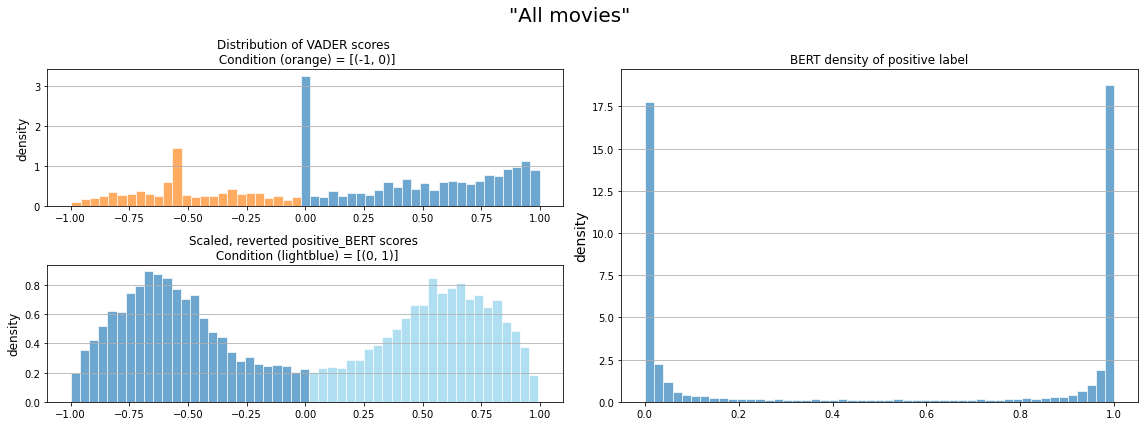

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0), positive_BERT = (0.5, 1)

Quote w. index 18635:
 a medium close-up of her face and shoulders; a less revealing version of Gal Gadot's Wonder Woman pose on a rocky outcrop and one with the Captain in full battle mode, punching up to connect with the mechanised fist of a much larger robotic creature

Quote w. index 51373:
 Disney wants to open up the Star Wars timeline and appeal to a more Game of Thrones style audience.

Quote w. index 27770:
 I think you'll get to see in this and Black Panther... is that it introduces in an organic way the technology and the mystery of the country. That is all part of Infinity War, using it to the advantage of the Avengers and the Guardians. So, I think that's what you will see,

Quote w. index 35325:
 They're very different movies and tonally they're very different movies, which is why we did not want to say Part 1 and Part 2, but they're very dir

In [68]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,0), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0), second_bound=(0.5, 1))

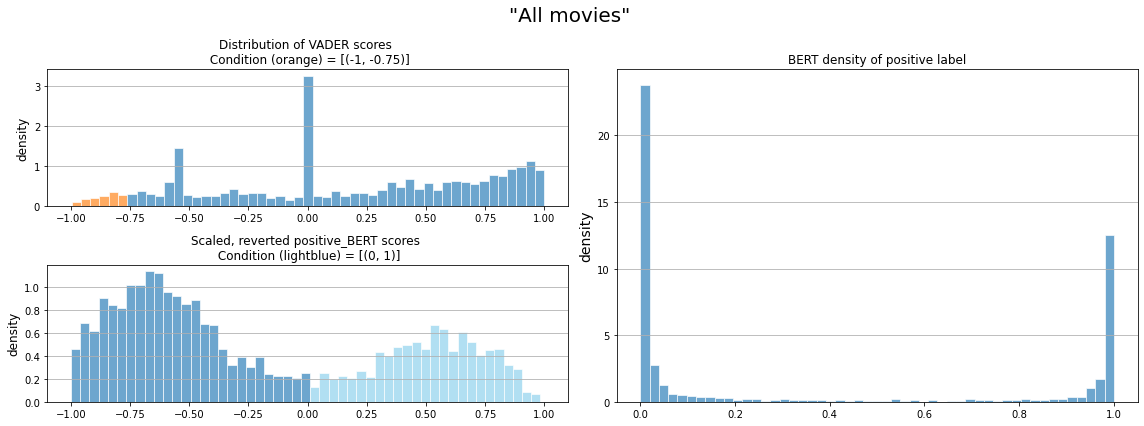

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, -0.75), positive_BERT = (0.5, 1)

Quote w. index 22034:
 It's the longest `Star Wars' movie, at two and a half hours, but it doesn't feel that way... it's like a bat out of hell, it takes off and never [ slows down ].

Quote w. index 1676:
 We find Finn, he's in incredible danger and the way in which he decides to react to this danger changes his life and launches him into the Star Wars universe in a very unique way. So I can't wait for you guys to see it.

Quote w. index 41884:
 My suspicion is after Endgame there's going to be another complete reboot that involves all of the new people we know about now and all of the new threats. It doesn't get easier for SHIELD ever.

Quote w. index 32040:
 A career criminal and hitman. Wild and unpredictable but he lives for the action. „ -- Rockstar Games. Micah Bell is an experienced outlaw and member of the Van der Linde gang, working as a hitm

In [69]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.75), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, -0.75), second_bound=(0.5, 1))

**Comments:**
From the first of the two conditionings above we see that the BERT score are labelled negative almost as frequently as positive when looking at all quotes classified as negative by VADER (VADER score below 0). So the two approaches disagree on half of the labels classified as negative by VADER. From the second conditioning we see that this tendency reduces when looking at the strongly negative quotes classified by VADER where the BERT distribution gets more negative as well but still labels a large amount of the (negative by VADER) quotes as positive.

From the randomly chosen quotes we realize that Star Wars or in general the word "War" occur a lot in the quotes - especially for the strongly negative quotes. We will get back to this later.

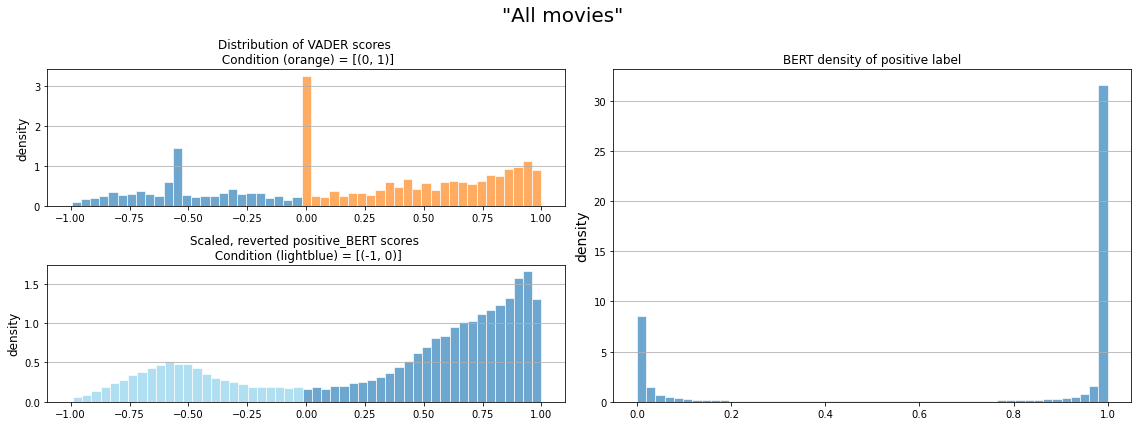

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0, 1), positive_BERT = (0, 0.5)

Quote w. index 37872:
 This is `Deadpool 2,' not `Titanic.' You're at, like, an 11 -- we need to get you down to a five, five 1/2, tops. Just phone it in, '

Quote w. index 37386:
 We meet on a regular basis with our Marvel team, and we've plotted out Marvel movies that will take us well into the next decade. I'm guessing we will try our hand at what I'll call a new franchise beyond Avengers, but that doesn't necessarily mean you won't see more Avengers down the road. We just haven't made any announcements about that. [... ] Given the popularity of the characters and given the popularity of the franchise, I don't think people should conclude there will never be another Avengers movie.

Quote w. index 40481:
 With Captain Marvel? That's why I'm saying. Let's make a love triangle. Let's make an MCU, oh my gosh, let's make an MCU like thriller. You know those 

In [70]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0, 1), second_bound=(0, 0.5))

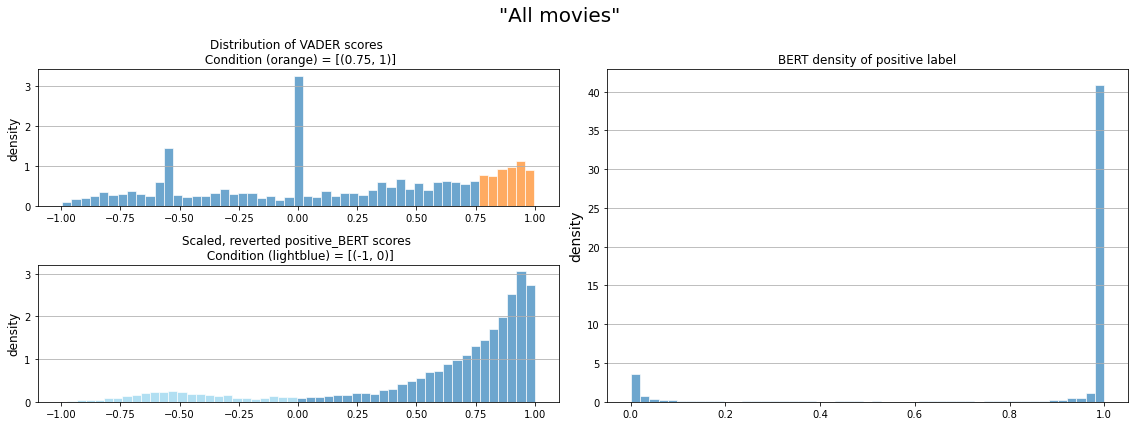

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.75, 1), positive_BERT = (0, 0.5)

Quote w. index 28035:
 Essentially, in this film, I have a new suit, which Tony Stark gave me, its an upgrade, and it's too fantastical to exist in real life. I have to wear pajamas, I wear these pajamas with balls on them that light up. It's super cool. It's not. I'm on set with the Avengers who are wearing costumes that cost hundreds of thousands of dollars, made by the best seamstresses you can imagine, and I'm there in a suit made by Marks and Spencer.

Quote w. index 8886:
 The Freedman's Bureau Act created the Freedman's bank. The Freedman's bank's mission was to teach free slaves about money. That's basically a then-day version of what we call financial literacy. When you think about this, the president of the United States, after the Emancipation Proclamation, after the Civil War, thought the most important thing that he could do to set former sl

In [71]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.75,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.75, 1), second_bound=(0, 0.5))

**Comments:** 
On the other hand the tendency is remarkably different when conditioning on the positively labelling by VADER of the scores. For positively labelled quotes by VADER, BERT generally agrees but labels a small amount of quotes as negative. However, when VADER predicts quotes strongly positive, almost all of the BERT predicitons are positive too.

With regards to the random outputted examples it seems like "War" doesn't occur as much and that the quotes are in general longer than the mistakes when conditioning with negative VADER predicions. However, we are aware that the randomly outputted 5 quotes are not representative for all of the disagreeing labelled quotes.

We will now look at the representation of the movies when checking the above conditions to investigate whether there is a trend between the disagreeing of the labelling of quotes and the movies they concern. The following function is used for analyzing this through horizontal bar plots.

In [72]:
def barplotWithCondition(df, VADER_bounds, BERT_bounds):

    posBERT_scores = df['positive_BERT_score'] # pd.Series([score_dict[0]['score'] for score_dict in df["positive_BERT"]])
    VADER_scores = df['VADER_score'] #pd.Series([score_dict[0]['score'] for score_dict in df["sentiment_VADER"]])
    VADER_statement = np.logical_and(VADER_scores > VADER_bounds[0], VADER_scores < VADER_bounds[1])
    BERT_statement = np.logical_and(posBERT_scores > BERT_bounds[0], posBERT_scores < BERT_bounds[1])

    condition = np.logical_and(VADER_statement, BERT_statement)

    title, count = np.unique(df.movie[condition], return_counts=True)
    count, title = np.array(list(zip(*sorted(zip(count, title), reverse=False))))
    count = np.array([int(number) for number in count])

    plt.figure(figsize=(16,10))
    plt.title(f"Quotes about movies \n VADER condition: {VADER_bounds}, BERT condition: {BERT_bounds}", fontsize=20)
    plt.xlabel("count", fontsize=12)
    plt.barh(title, count, alpha=0.65)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

We start by visualizing the unconditioned distribution of movies to have as a comparison.

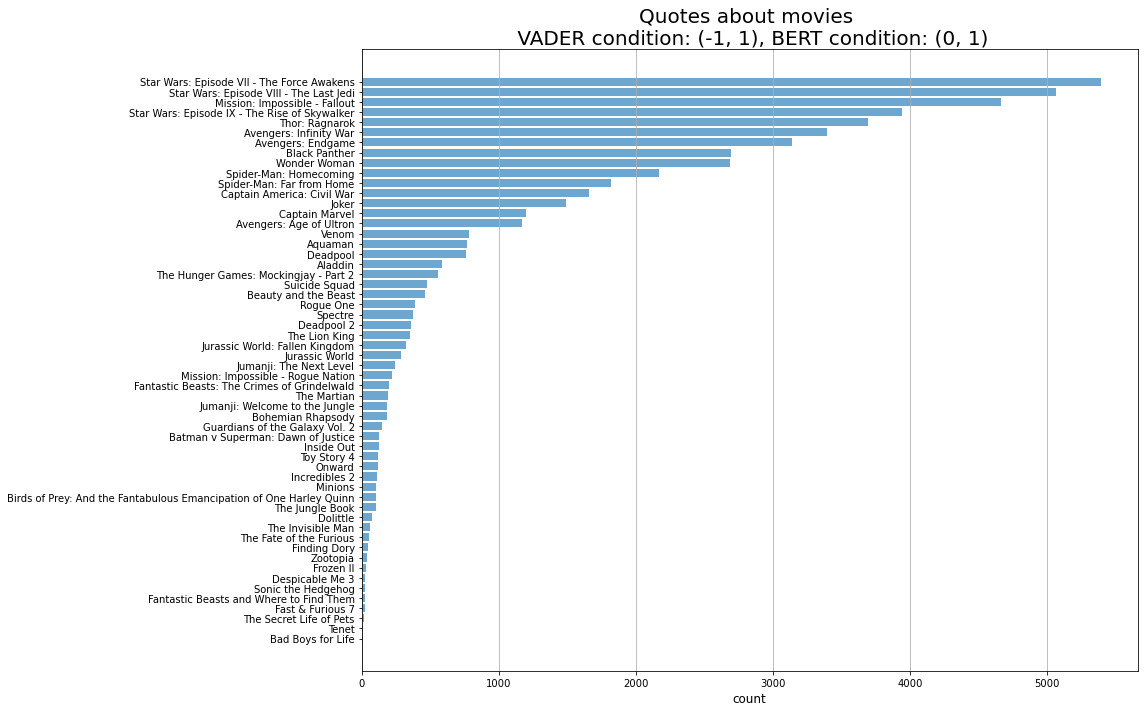

In [73]:
barplotWithCondition(df, VADER_bounds=(-1, 1), BERT_bounds=(0, 1))

Then we do the investigation with the same condition as in the previous investigation where we first look at the negatively labelled VADER predictions.

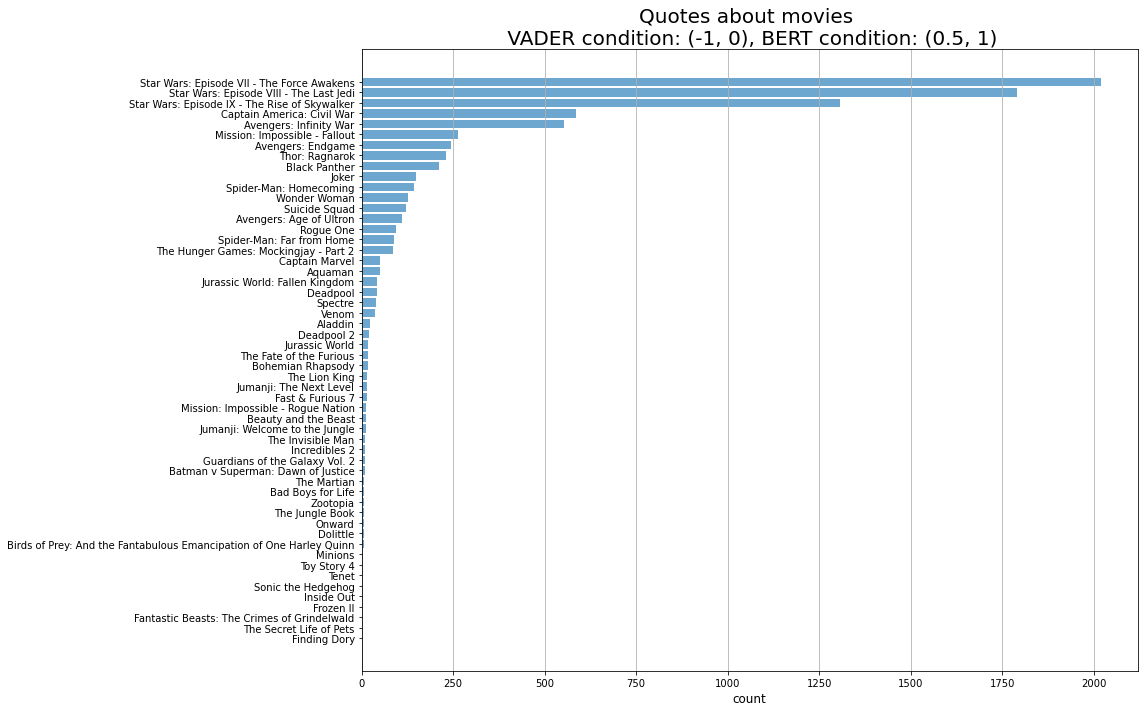

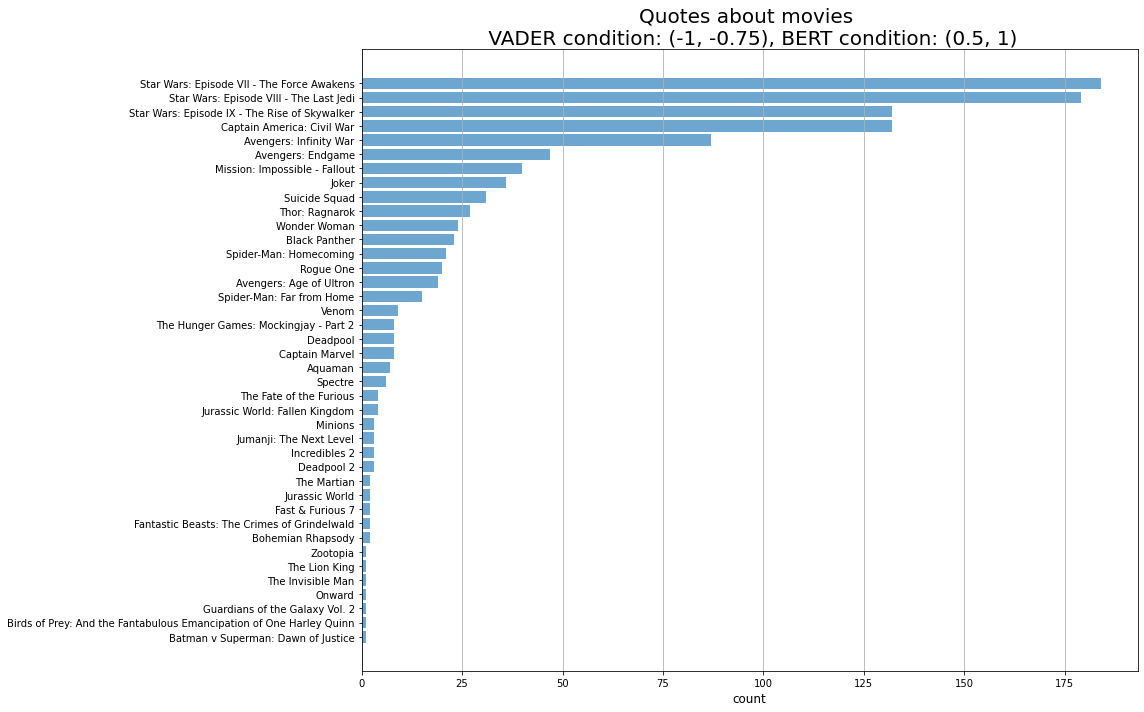

In [76]:
barplotWithCondition(df, VADER_bounds=(-1, 0), BERT_bounds=(0.5, 1))
barplotWithCondition(df, VADER_bounds=(-1, -0.75), BERT_bounds=(0.5, 1))

Even though Star Wars and other movie titles that have a negative title are quite highly represented without conditioning on the data it still seems like conditioning on negative VADER labels exagerates this tendency. Also it seems like the above plot (conditioning on negative VADER) kind of ranks the scores from most negatively to most positively associated movie title. In other words negative VADER labels that are positively labelled by the transformer in general concern movies with negative titles. Even though this tendency sounds like a good feature of the VADER approach we do not prefer this to the BERT as we do not want the sentiment score to reflect the sentiment of the movie title but rather the context in which it appears.

As we see below, there is not the same tendency for the disagreeing labelling when conditioning on positive VADER labels - it ressembles the original distribution more even though it is hard to say as we have a lot fewer data points with this conditioning.

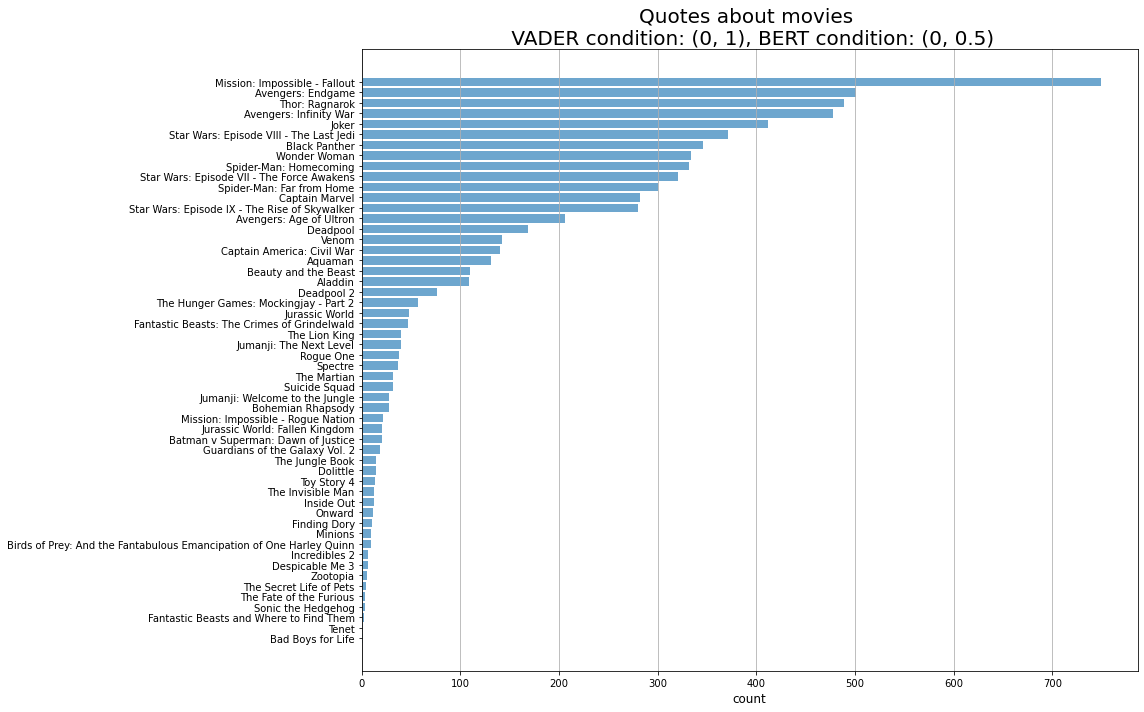

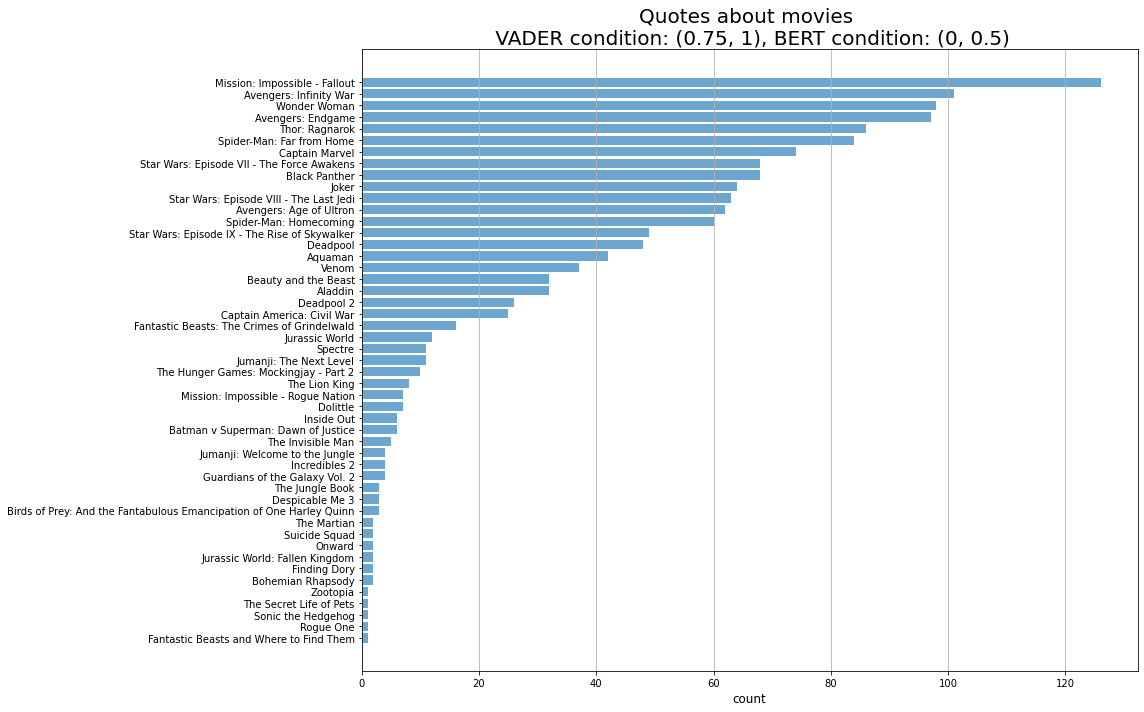

In [75]:
barplotWithCondition(df, VADER_bounds=(0, 1), BERT_bounds=(0, 0.5))
barplotWithCondition(df, VADER_bounds=(0.75, 1), BERT_bounds=(0, 0.5))

### Discussion and comments on different sentiment scores

Both approaches have pros and cons - here is a summary of them and an evaluation of which approach will be used as the main one for the future investigations.

VADER seems to struggle with interpreting larger semantical structures in the sentence compared to the transformer based labelling which was seen through conditioning plots of score and movie title distributions and the qualitative analysis of quotes that has different labels with the two approaches. This conclusion is based on the fact that strongly negative scores from the VADER approach are labelled almost equally much as positive or negative with the BERT transformer approach. Through further conditioning investigations we saw that the quotes causing a difference in labelling between the two approaches tend to concern specific movies or the length of the quote (depending on whether positive or negative conditions were used). For instance, it seems like the thing that causes BERT to label many of the quotes labelled as strongly negative by VADER is that VADER does not catch the semanticly neutral sentiment of the word "War" when "War" is part of a movie title where BERT does not associate a negative sentiment with this. 

On the other hand, BERT predicts using the probability outcome of a softmax function and is in general very certain about its predictions. This mean that it does not make sense to infer a neutral sentiment assignment with this pretrained BERT transformer which is definetely a con of the transformer approach as not all quotes need to be associated with EITHER a positive or a negative score.

Anyhow, we choose to continue with the transformer-based approach as it - as seen from initial analyses - is able to capture a more valid semantical understanding of quotes, which we weigh higher than the ability to do a neutral classification. We will however keep both but prioritize the BERT for further analyses. 

### AD(A)itional feature

Also applicable on the movie level - for instance we can analyze the same trends on the Top 2 most quoted movies.

In [77]:
title, count = np.unique(df.movie, return_counts=True)
count_sorted, title = np.array(list(zip(*sorted(zip(count, title), reverse=True))))

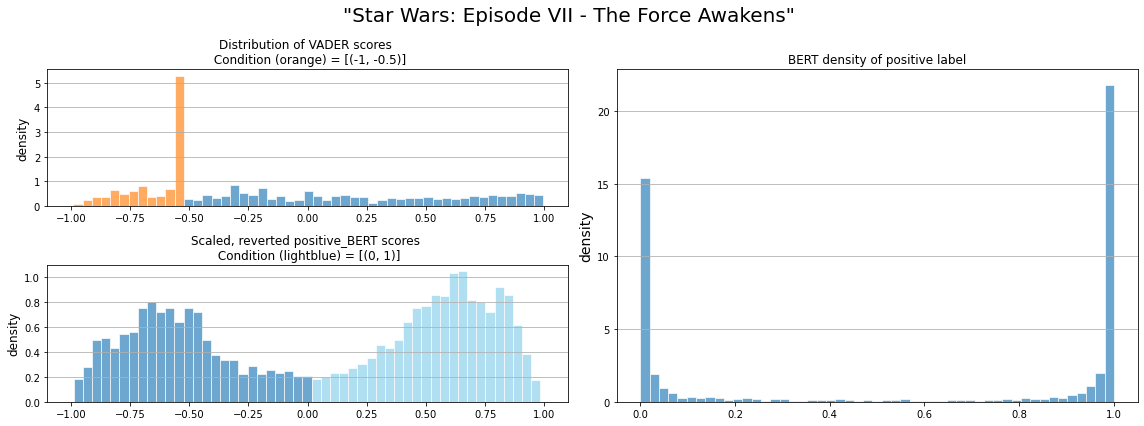

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0.75), positive_BERT = (0.5, 1)

Quote w. index 7217:
 The music of `Star Wars' is defined by a culmination of many factors,

Quote w. index 6818:
 Hi, I'm John. I'm going to be in `Star Wars.' If he has time, can mentor me?

Quote w. index 1110:
 We are proud to bring our audience a third season of Star Wars Rebels, a series that has resonated across generations. The creative team behind the series continues to do a brilliant job in delivering on the key tenets that fans have come to expect from a Star Wars property, including adventure, hope and the battle between good vs. evil.

Quote w. index 4146:
 Expressing my duality and accessing new superpowers is important to me. I'm also a huge Star Wars fan so I was geeking out the entire time!

Quote w. index 6835:
 Fun, fresh-faced leads; a terrifying, three-dimensional villain; a lightsaber battle for the ages. Fear not, Star Wars fans:

In [80]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[0])

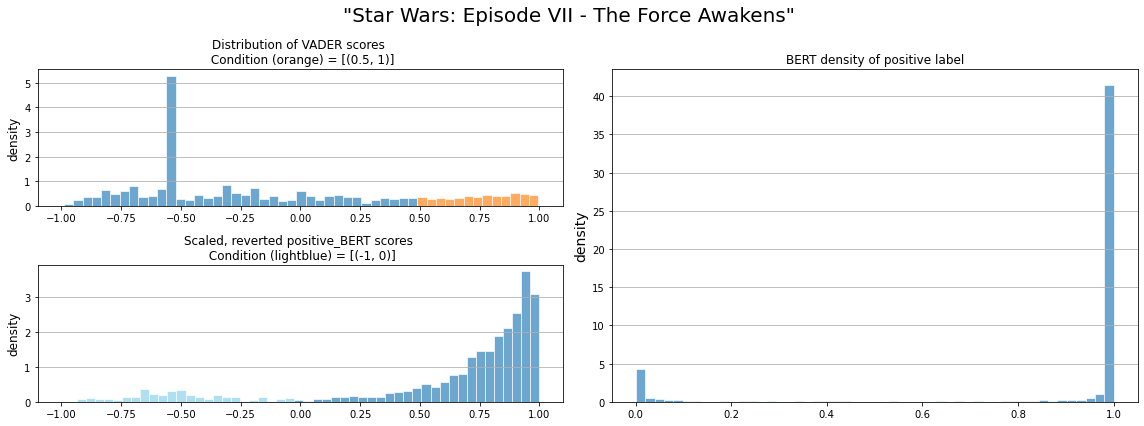

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.5, 1), positive_BERT = (0, 0.5)

Quote w. index 426:
 It looks like it's gon na happen so I'm very excited. I can't talk too much about it. The script is hard to get. They told me they'd cut my finger if I talk about it. I saw the original [ Star Wars ] when it came out and it marked me. I was impressed by the film and by the characters and by the story and the message...

Quote w. index 5224:
 It really looks like the best of the `Star Wars' movies-but then, I am emotionally flushed.

Quote w. index 6210:
 I was particularly attracted to the idea of picking up and-J.J. got very excited about the notion of shaping the next trilogy, and that idea was interesting to me too. But I kind of, I'm writing a sequel to The Incredibles and I can't think too much farther beyond that. I have other things I want to do as well. [... ] in fact just avoid all this Star Wars stuff. Everybody's feeding to

In [81]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[0])

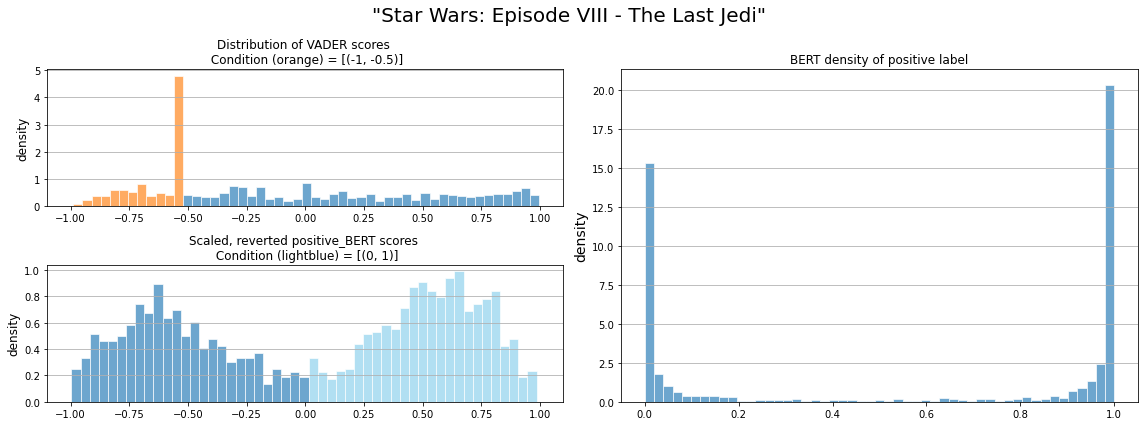

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0.75), positive_BERT = (0.5, 1)

Quote w. index 12395:
 When they dropped that trailer, things got crazy. I'm excited, but I'm also very scared because this is all that matters to me right here. When I'm by myself, I'm really cool and nice to everyone, but then the whole paparazzi thing? If you see me with my kids, I change. I just want them not to deal with that. I'm just Papa to them. We don't watch TV. We haven't even seen Star Wars yet.

Quote w. index 18498:
 more heroes and characters across multiple Star Wars eras

Quote w. index 13247:
 I think that there are much bigger surprises in The Last Jedi [ than in The Force Awakens ],

Quote w. index 18556:
 J.J. Abrams, who launched a new era of Star Wars with The Force Awakens in 2015, is returning to complete the sequel trilogy as writer and director of Star Wars: Episode IX. Abrams will co-write the film with Chris Terrio. Star Wa

In [82]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[1])

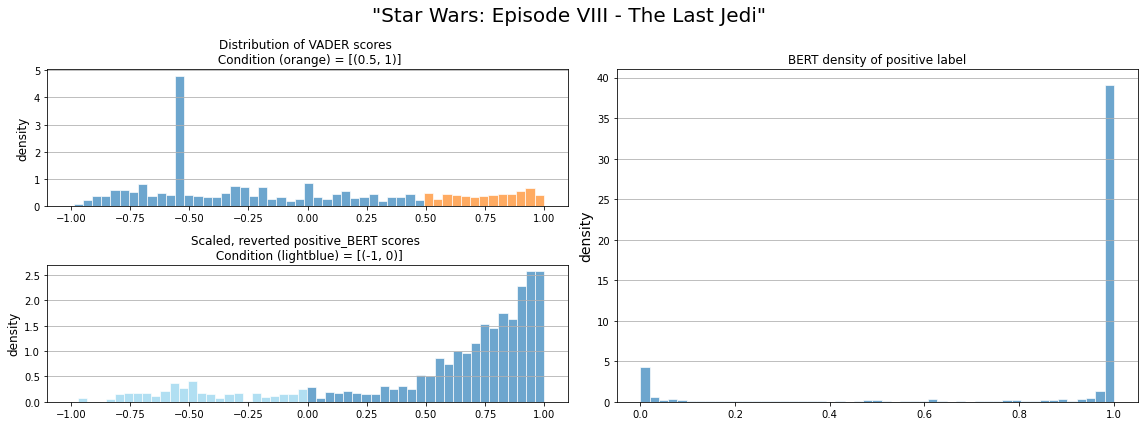

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.5, 1), positive_BERT = (0, 0.5)

Quote w. index 17533:
 They may reduce the emissions from the country's cattle, your honour. Those are not Star Wars technologies,

Quote w. index 18668:
 I only know that the petition, which was made in a moment of compromised common sense, can't achieve the goal that was set for it. It was meant as a way to blow off steam, and in the grand scope of realism there is a 0% chance that Disney would strip TLJ from canon, and they absolutely won't delay Episode IX to remake Episode VIII. That was a flight of fancy, and a sarcastic statement.

Quote w. index 12622:
 It's something that, again it's like, I would be intrigued. I don't know, it's very difficult. What is dangerous with Star Wars right now is it's become its own vocabulary. I would love to see them, I think Rogue One was a very interesting attempt to get out of the mold... I think it would be a gre

In [83]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[1])

Having created the sentiment score in preprocessing, we now just check for the two quotes with minimum (i.e. most negative) and maximum (i.e. most positive) sentiment according to the VADER and BERT sentiment lexicon. 

In [84]:
print("Quote with minimum VADER sentiment:\n")
print(df.loc[VADER_scores.argmin()].quotation)

Quote with minimum VADER sentiment:

Mockingjay, may your aim be as true as your heart is pure. „ ~ The end of Coin's hypocritical speech during Snow's execution-her last words. During the 75th Hunger Games, President Coin starts the second rebellion against the Capitol to take control over Panem. As she needs Katniss Everdeen for her unique position as a symbol of rebellion to the districts, she rescues her, Finnick Odair and Beetee from the arena and hide them in District 13. This caused the Capitol to bomb District 12, Katniss's home, but Coin showed little emotion to this. However, Coin soon discovers it is hard to cooperate with Katniss, who dislikes her for her selfishness and ruthlessness. Coin often regrets openly she couldn't have saved the more charismatic Peeta from the arena instead of Katniss. Before the attack on the Capitol, Coin realizes Katniss could menace her position of President, as people still love Katniss more than her. To destroy her rival's psyche completely, 

In [85]:
print("Quote with maximum VADER sentiment:\n")
print(df.loc[VADER_scores.argmax()].quotation)

Quote with maximum VADER sentiment:

Starring in Avengers: Infinity War is BAFTA Award nominee Chris Hemsworth as Thor, Academy Award nominee Josh Brolin as Thanos, Saturn Award Winner Chris Pratt as Star Lord / Peter Quill, Teen Choice Awards nominee Sebastian Stan as Bucky, four-time Golden Globe Award nominee Scarlett Johansson as Natasha Romanoff / Black Widow, Academy Award nominee Benedict Cumberbatch as Dr. Stephen Strange, Academy Award winner Brie Larson as Carol Danvers / Captain Marvel, ALMA Award winner Zoe Saldana as Gamora, Empire Award winner Karen Gillan as Nebula, two-time Academy Award nominee Jeremy Renner as Clint Barton / Hawkeye, two-time Saturn Award nominee Chris Evans as Steve Rogers / Captain America, BAFTA Awards nominee Elizabeth Olsen as Wanda Maximoff / Scarlet, four-time Academy Award nominee Bradley Cooper as Rocket Raccoon, Screen Actors Guild Awards nominee Vin Diesel as Groot, Academy Award nominee Samuel L. Jackson as Nick Fury, Screen Actors Guild A

In [86]:
print("Quote with minimum BERT sentiment:\n")
print(df.loc[posBERT_scores.argmin()].quotation)

Quote with minimum BERT sentiment:

Suicide Squad is just bad. It's ugly and boring, a toxic combination that means the film's highly fetishized violence doesn't even have the exciting tingle of the wicked or the taboo.


In [87]:
print("Quote with maximuma BERT sentiment:\n")
print(df.loc[posBERT_scores.argmax()].quotation)

Quote with maximuma BERT sentiment:

To work on Fantastic Beasts is a wonderful musical opportunity,
